<i> Nos données datent de 1980, cependant l'accès aux données a évolué avec le temps et il se peut que certaines données soient manquantes. Néanmoins, les données sur les catastrophes naturelles restent cependant assez fiables

# Import des librairies utilisées lors de l'analyse et traitement des données

In [38]:
# Importing libraries neeeded for the project
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## Nettoyage des données du CSV : "Climate Disasters Frequency.csv"

In [39]:
# Lit le fichier csv et le stocke dans df_disasters
df_disasters = pd.read_csv("Climate Disasters Frequency.csv", delimiter=",")

# Supprime les colonnes inutiles
df_disasters = df_disasters.drop(columns=["ObjectId", "Country", "ISO2", "Unit", "Source", "CTS_Code", "CTS_Name", "CTS_Full_Descriptor"])

# Renomme les colonnes des années qui commencent par "F" en enlevant le "F" préfixe
df_disasters = df_disasters.rename(columns=lambda x: x[1:] if x.startswith("F") else x)

# Renomme les valeurs de Indicator en gardant uniquement le nom de la catastrophe
str_to_remove = "Climate related disasters frequency, Number of Disasters: "
df_disasters["Indicator"] = df_disasters["Indicator"].str.replace(str_to_remove, "")

# Supprime les lignes où indicator est égal à "TOTAL"
df_disasters = df_disasters[df_disasters["Indicator"] != "TOTAL"]

# Affiche les 20 premières lignes du dataframe
df_disasters.head(10)

,ISO3,Indicator,1980,1981,1982,1983,1984,1985,1986,1987,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFG,Drought,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN
1,AFG,Extreme temperature,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Flood,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,2.0,1.0,4.0,1.0,3.0,6.0,5.0,2.0,5.0
3,AFG,Landslide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,NaN,4.0,NaN,2.0,1.0,1.0,1.0,1.0,1.0
4,AFG,Storm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN
6,AFG,Wildfire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ALB,Drought,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ALB,Extreme temperature,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
9,ALB,Flood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN
10,ALB,Landslide,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Crée une liste des catastrophes
disasters = df_disasters["Indicator"].unique()
disasters = disasters.tolist()
disasters

['Drought', 'Extreme temperature', 'Flood', 'Landslide', 'Storm', 'Wildfire']

## Nettoyage des données du CSV : "Atmospheric CO2 Concentrations.csv"

In [41]:
# Lit le fichier csv et le stocke dans df_emissions
df_emission = pd.read_csv('Atmospheric CO2 Concentrations.csv', delimiter=',')

# Supprime les lignes où l'unité est en pourcent
df_emission = df_emission[df_emission['Unit'] != 'Percent']

# Convertit les dates en datetime
df_emission['Date'] = pd.to_datetime(df_emission['Date'], format='%YM%m')

# Extrait l'année de la date et le rajoute dans une colonne "Year"
df_emission['Year'] = df_emission['Date'].dt.year

# Groupe les données par année
df_emission = df_emission.groupby('Year')['Value'].mean().reset_index()

df_emission.head(10)

,Year,Value
0,1958,315.232000
1,1959,315.980833
2,1960,316.910000
3,1961,317.644167
4,1962,318.454167
5,1963,318.992500
6,1964,319.616667
7,1965,320.035833
8,1966,321.369167
9,1967,322.180833


## Création d'un dataframe groupant par catastrophe

In [42]:
# Dataframe avec les occurences de catastrophes par année dans le monde
df_disasters_world = df_disasters.groupby("Indicator").sum().reset_index()
df_disasters_world["ISO3"] = "WLD"
df_disasters_world

,Indicator,ISO3,1980,1981,1982,1983,1984,1985,1986,1987,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Drought,WLD,24.0,18.0,6.0,26.0,6.0,3.0,4.0,15.0,...,9.0,20.0,27.0,14.0,12.0,17.0,15.0,12.0,16.0,22.0
1,Extreme temperature,WLD,3.0,1.0,2.0,2.0,1.0,7.0,2.0,5.0,...,13.0,17.0,12.0,12.0,10.0,27.0,21.0,5.0,3.0,12.0
2,Flood,WLD,39.0,38.0,47.0,48.0,46.0,56.0,48.0,65.0,...,148.0,136.0,161.0,159.0,127.0,127.0,195.0,201.0,222.0,176.0
3,Landslide,WLD,3.0,7.0,12.0,16.0,6.0,4.0,9.0,14.0,...,11.0,15.0,20.0,13.0,25.0,12.0,25.0,19.0,12.0,17.0
4,Storm,WLD,34.0,46.0,51.0,55.0,51.0,49.0,53.0,55.0,...,105.0,98.0,121.0,86.0,126.0,94.0,91.0,127.0,119.0,105.0
5,Wildfire,WLD,1.0,2.0,2.0,10.0,7.0,11.0,5.0,7.0,...,10.0,4.0,13.0,10.0,15.0,10.0,14.0,9.0,19.0,15.0


# Création d'un diagramme camembert

In [43]:
year = "2018"
iso3 = "FRA"

df_pie = df_disasters.loc[df_disasters["ISO3"] == iso3]
df_pie = df_pie[["Indicator", year]]
df_pie

,Indicator,2018
305,Drought,NaN
306,Extreme temperature,2.0
307,Flood,2.0
308,Landslide,NaN
309,Storm,3.0
311,Wildfire,NaN


In [44]:
fig = go.Figure(data=[go.Pie(labels=df_pie["Indicator"], values=df_pie[year], textinfo='label+percent')])
fig.show()


TypeError: unhashable type: 'numpy.ndarray'

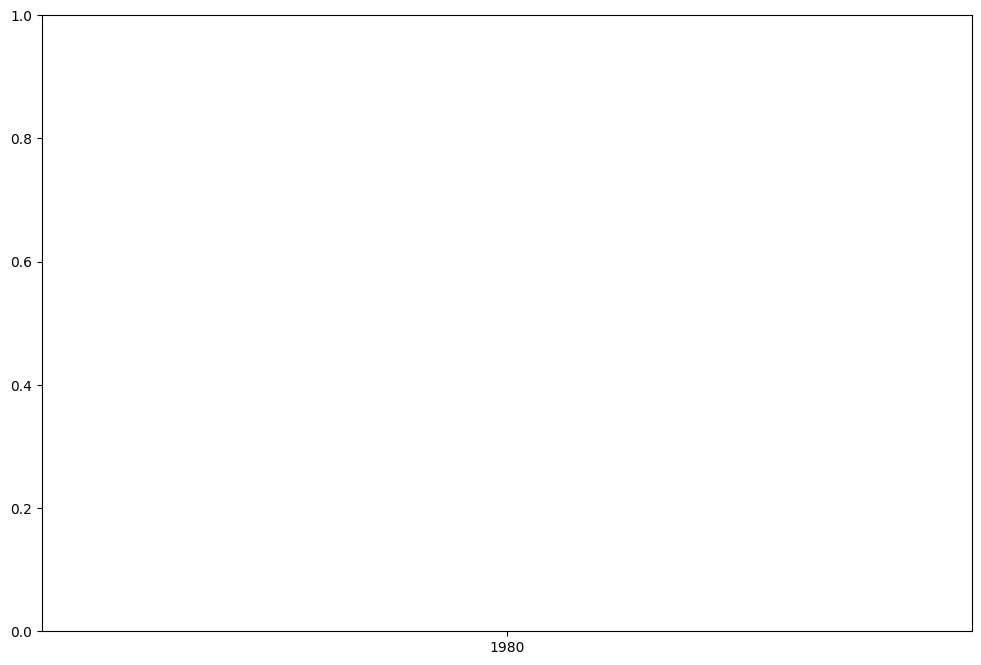

In [45]:
# Sélectionnez les colonnes à partir de la 2e colonne (1980 et suivantes)
columns_to_plot = df_disasters_world.columns[2:]
rows_to_plot = df_disasters_world


# Créez le graphique en barres juxtaposées
plt.figure(figsize=(12, 8))
for index, row in df_disasters.iterrows():
    plt.bar(columns_to_plot, rows_to_plot, label=row['Indicator'], alpha=1)


plt.xlabel('Année')
plt.ylabel('Nombre de catastrophes')
plt.title('Évolution des catastrophes naturelles par année')
plt.legend(disasters)
plt.show()
